## Functionality to combine visualizations

In [1]:
import warnings
warnings.filterwarnings('ignore')
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
%matplotlib inline  

import numpy as np  
from matplotlib import rc
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle

from models.binary_model.binary_model import BinaryModel
from models.ind_model.ind_model import OvAModel
from models.multi_model.multi_model import MultiModel


from thex_data.data_consts import *
from mainmodel.helper_compute import *
from mainmodel.helper_plotting import *
from utilities import utilities as thex_utils




mags = ["g_mag",  "r_mag", "i_mag", "z_mag", "y_mag",
        "W1_mag", "W2_mag",
        "J_mag", "K_mag", "H_mag"]

# EXPS_DIR = ROOT_DIR + "/../../exps/paper_set_05_31_2021/"

codes= ["A1", "F1", "B1", "G1"]
 
# rc('text', usetex=True)
mpl.rcParams['font.serif'] = ['times', 'times new roman']
mpl.rcParams['font.family'] = 'serif'

In [ ]:
# Multi 
multi_model = MultiModel(cols = mags,
                       folds = 10,
                       transform_features = True, 
                         case_code = codes,
                       balanced_purity = True) 
multi_model=load_prev_exp(EXPS_DIR, "multi/", multi_model)



In [ ]:
# Binary
model2 = BinaryModel(cols = mags,
                       folds = 10,
                       transform_features = True, 
                     case_code = codes,
                       balanced_purity = True)
binary_model = load_prev_exp(EXPS_DIR, "binary/", model2)



In [ ]:
# OvA 
model = OvAModel(cols = mags,
               folds = 10,
               transform_features = True, 
                 case_code = codes,
               balanced_purity = True,
               identified_only=True)

ova_model = load_prev_exp(EXPS_DIR, "ova/", model) 

## Merge purity/comp average plots

Below is the code to merge the OVA and multi KDE purity/comp plots. 
To plot the binary on it owns use the plot_all_metrics in vis.py 

In [ ]:
pc_per_trial = multi_model.get_pc_per_trial(multi_model.results)
pc_per_trial
for m in pc_per_trial:
    print(m[0]['TDE'])

In [ ]:
def get_metrics_ax(model, pur_ax, comp_ax):
    c_baselines, p_baselines = compute_baselines(
        model.class_counts, 
        model.class_labels,
        model.get_num_classes(), 
        model.balanced_purity,  
        model.class_priors)
    pc_per_trial = model.get_pc_per_trial(model.results)
    ps, cs = model.get_pc_performance(pc_per_trial)
    p_intvls, c_intvls =compute_confintvls(pc_per_trial, model.class_labels, model.balanced_purity)
    
    y_indices, class_names=model.plot_metrics_ax(pur_ax, ps, "Balanced Purity", p_baselines, p_intvls)

    y_indices, class_names=model.plot_metrics_ax(comp_ax, cs, "Completeness", c_baselines, c_intvls)
    return y_indices, class_names
# Plot Multi & OVA
f, ax = plt.subplots(nrows=2, ncols=2,
                     sharex=True, sharey=True,
                     figsize=(8,8),  dpi=600)
rc('text', usetex=True)
mpl.rcParams['font.serif'] = ['times', 'times new roman']
mpl.rcParams['font.family'] = 'serif'
print("\n --------------------------- ova_model--------------------------- \n\n")
get_metrics_ax(ova_model, ax[0][0], ax[0][1]) 

print("\n --------------------------- multi_model--------------------------- \n\n")
y_indices, class_names=get_metrics_ax(multi_model, ax[1][0], ax[1][1]) 

ax[0][0].tick_params(direction="in")
ax[0][1].tick_params(direction="in")
ax[0][1].text(1.05,2.1, "OVA", fontsize=20)
ax[1][1].text(1.05,2.1, "Multiclass\nKDE", fontsize=20)
plt.subplots_adjust(wspace=0, hspace=0)
ax[0][0].set_yticks(y_indices)
ax[0][0].set_yticklabels(clean_class_names(class_names),
           fontsize=16,  horizontalalignment='right')
ax[1][0].set_yticks(y_indices)
ax[1][0].set_yticklabels(clean_class_names(class_names),
           fontsize=16,  horizontalalignment='right')
plt.xticks(np.linspace(0,1,10, endpoint=False))

ax[1][0].set_xlabel("Balanced Purity (\%)", fontsize=TICK_S)
ax[1][1].set_xlabel("Completeness (\%)", fontsize=TICK_S)
plt.savefig("../output/custom_figures/multis_metrics.pdf", bbox_inches='tight')
plt.show()

In [ ]:
#  Binary

f, ax = plt.subplots(nrows=1, ncols=2,
                     sharex=True, sharey=True,
                     figsize=(6,3),  dpi=600)
rc('text', usetex=True)
mpl.rcParams['font.serif'] = ['times', 'times new roman']
mpl.rcParams['font.family'] = 'serif'
 
y_indices, class_names=get_metrics_ax(model = binary_model, pur_ax = ax[0], comp_ax = ax[1] )

ax[0].tick_params(direction="in")
ax[1].tick_params(direction="in")

plt.subplots_adjust(wspace=0, hspace=0)

ax[0].set_yticks(y_indices)
ax[0].set_yticklabels(clean_class_names(class_names),
           fontsize=14,  horizontalalignment='right')
plt.xticks(np.linspace(0,1,10, endpoint=False))
ax[0].set_xlabel("Balanced Purity (\%)", fontsize=14)
ax[1].set_xlabel("Completeness (\%)", fontsize=14)
plt.savefig("../output/custom_figures/binary_metrics.pdf", bbox_inches='tight')
plt.show()

## Plot probability plots together

### Empirical Probabilities

In [ ]:
cur_model = multi_model
cur_model.range_metrics = cur_model.compute_probability_range_metrics(
        cur_model.results, bin_size=0.2)

In [ ]:
cur_model.class_labels

In [ ]:
[0, 1, 3, 7]

In [ ]:

# call outs for multi only
indices = [0, 1, 3, 7, 10]
rc('text', usetex=True)
cur_model = multi_model


class_labels = cur_model.class_labels 

num_classes = len(indices)

f, ax = plt.subplots(nrows=1,
                     ncols=len(indices),
                     sharex=True, sharey=True,
                     figsize=(8, 1.9),
                     dpi=280)
row_index = 0
for index in indices: 
    cn = cur_model.class_labels[index]
    plot_model_rates(cn, cur_model, ax[row_index])  
    ax[row_index].text(-0.45, 0.81, clean_class_name(cn), fontsize=14)
#     plot_model_rates(cn, ova_model, ax[row_index][1])
    row_index+=1
    
y_indices = [0.1, 0.3, 0.5, 0.7, 0.9]
y_ticks = ["10", "30", "50", "70", "90"]
# x and y indices/ticks are the same
plt.xticks(np.arange(5), y_ticks)
plt.yticks(y_indices, y_ticks)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

mpl.rcParams['font.serif'] = ['times', 'times new roman']
mpl.rcParams['font.family'] = 'serif'

f.text(0.5, -0.07, 'Assigned Probability ' + r' $\pm10\%$', fontsize=14, ha='center')
f.text(0.05, .5, r'Empirical Prob. ($\%$)',
       fontsize=14, va='center', rotation='vertical')
plt.subplots_adjust(wspace=0, hspace=0)
f.savefig(ROOT_DIR + "/output/custom_figures/prob_callouts.pdf", bbox_inches='tight')
plt.show()

In [ ]:
ova_model.range_metrics = ova_model.compute_probability_range_metrics(
        ova_model.results, bin_size=0.2)
binary_model.range_metrics = binary_model.compute_probability_range_metrics(
        binary_model.results, bin_size=0.2)
multi_model.range_metrics = multi_model.compute_probability_range_metrics(
        multi_model.results, bin_size=0.2)

In [ ]:
plot_rates_together(binary_model, ova_model, multi_model, indices=[0,1,2,3,4,5])

plot_rates_together(binary_model, ova_model, multi_model, indices=[6,7,8,9,10])

### Purity /completeness curves vs probability threshold

In [ ]:
plot_pc_curves_together(binary_model, ova_model, multi_model, indices=[0,1,2,3,4,5])
plot_pc_curves_together(binary_model, ova_model, multi_model, indices=[6,7,8,9,10])

plot_pc_curves_together(binary_model, ova_model, multi_model, indices=[2,5,8,9,10])


## Combining with vs without priors


In [2]:
EXPS_DIR = ROOT_DIR + "/../../exps/v8_db_runs/new_lsst_tests/"

In [3]:
NUM_FOLDS = 6
MIN_CLASS_SIZE = 3
MAX_CLASS_SIZE = 4220

modelwithout = MultiModel(cols = mags,
                       folds = NUM_FOLDS,
                       min_class_size = MIN_CLASS_SIZE,
                       max_class_size = MAX_CLASS_SIZE,
                       transform_features = True,
                       case_code = codes,
                       lsst_test= True)
 
multi_wo = load_prev_exp(EXPS_DIR, 
                         "Multiclass_Classifier1/", 
                         model=modelwithout)


Saving Multiclass Classifier output to directory /Users/marinaki/Documents/PhD/research/astro_research/code/thex_model/thex_data/../output/Multiclass_Classifier1


Constructing Class Hierarchy Tree...
Using data: /Users/marinaki/Documents/PhD/research/astro_research/code/thex_model/thex_data/../../../data/catalogs/v8/THEx-v8.0-release.mags-xcalib.min-xcal.fits

Grouping ['Ib', 'Ic', 'Ib/c']into Ibc

Grouping ['Unspecified II', 'IIn']into II (cust.)

Classes:
['Unspecified Ia', 'Ia-91bg', 'TDE', 'SLSN-I', 'Ibc', 'II (cust.)']

Features:
['g_mag', 'r_mag', 'i_mag', 'z_mag', 'y_mag', 'W1_mag', 'W2_mag', 'J_mag', 'K_mag', 'H_mag', 'g_mag_minus_r_mag', 'r_mag_minus_i_mag', 'i_mag_minus_z_mag', 'z_mag_minus_y_mag', 'K_mag_minus_W1_mag', 'W1_mag_minus_W2_mag', 'y_mag_minus_J_mag', 'H_mag_minus_K_mag', 'J_mag_minus_H_mag']


		Class Counts
Unspecified Ia : 4220
Ia-91bg : 101
TDE : 58
SLSN-I : 6
Ibc : 643
II (cust.) : 2497


In [4]:

multiwith = MultiModel(cols = mags,
                       folds = NUM_FOLDS,
                       min_class_size = MIN_CLASS_SIZE,
                       max_class_size = MAX_CLASS_SIZE,
                       transform_features = True,
                       case_code = codes,
                       priors=True, 
                       lsst_test= True)
multi_w = load_prev_exp(EXPS_DIR,  
                        "Multiclass_Classifier2/", 
                        model=multiwith)



Saving Multiclass Classifier output to directory /Users/marinaki/Documents/PhD/research/astro_research/code/thex_model/thex_data/../output/Multiclass_Classifier2


Constructing Class Hierarchy Tree...
Using data: /Users/marinaki/Documents/PhD/research/astro_research/code/thex_model/thex_data/../../../data/catalogs/v8/THEx-v8.0-release.mags-xcalib.min-xcal.fits

Grouping ['Ib', 'Ic', 'Ib/c']into Ibc

Grouping ['Unspecified II', 'IIn']into II (cust.)

Classes:
['Unspecified Ia', 'Ia-91bg', 'TDE', 'SLSN-I', 'Ibc', 'II (cust.)']

Class Priors:
{'Unspecified Ia': 0.56, 'Ia-91bg': 0.01, 'TDE': 0.01, 'SLSN-I': 0.0, 'Ibc': 0.09, 'II (cust.)': 0.33}

Features:
['g_mag', 'r_mag', 'i_mag', 'z_mag', 'y_mag', 'W1_mag', 'W2_mag', 'J_mag', 'K_mag', 'H_mag', 'g_mag_minus_r_mag', 'r_mag_minus_i_mag', 'i_mag_minus_z_mag', 'z_mag_minus_y_mag', 'K_mag_minus_W1_mag', 'W1_mag_minus_W2_mag', 'y_mag_minus_J_mag', 'H_mag_minus_K_mag', 'J_mag_minus_H_mag']


		Class Counts
Unspecified Ia : 4220
Ia-91bg : 101
TD

In [13]:
for k in multi_w.class_counts.keys():
    print(str(k) + " : " + str(multi_w.class_counts[k]/ sum(multi_w.class_counts.values())))

Unspecified Ia : 0.5607973421926911
Ia-91bg : 0.013421926910299004
TDE : 0.007707641196013289
SLSN-I : 0.0007973421926910299
Ibc : 0.0854485049833887
II (cust.) : 0.33182724252491697




 --------------- WITH Priors -------------------- 



		Multiclass Classifier Balanced Purity
Unspecified Ia : 0.18680230660493405
Ia-91bg : 0.2748107870863694
TDE : 0.7983243243371123
SLSN-I : 0
Ibc : 0.4337185209373308
II (cust.) : 0.32117455544972406


		Multiclass Classifier Purity
Unspecified Ia : 0.6294550708781147
Ia-91bg : 0.09722222222222222
TDE : 0.2757936507936508
SLSN-I : 0.0
Ibc : 0.16436819912299658
II (cust.) : 0.542727507136188


		Multiclass Classifier Completeness
Unspecified Ia : 0.8350774144359671
Ia-91bg : 0.03002450980392157
TDE : 0.1574074074074074
SLSN-I : 0.0
Ibc : 0.08243913695627092
II (cust.) : 0.32840170171555066


		Purity confidence intervals
Unspecified Ia : [0.6221319079755434, 0.636778233780686]
Ia-91bg : [0, 0.25734813718284094]
TDE : [0.09989718152483756, 0.45169012006246406]
SLSN-I : [0.0, 0.0]
Ibc : [0.13573719456383598, 0.19299920368215717]
II (cust.) : [0.5281785017228141, 0.5572765125495619]


		Completeness confidence intervals
Unspecified Ia

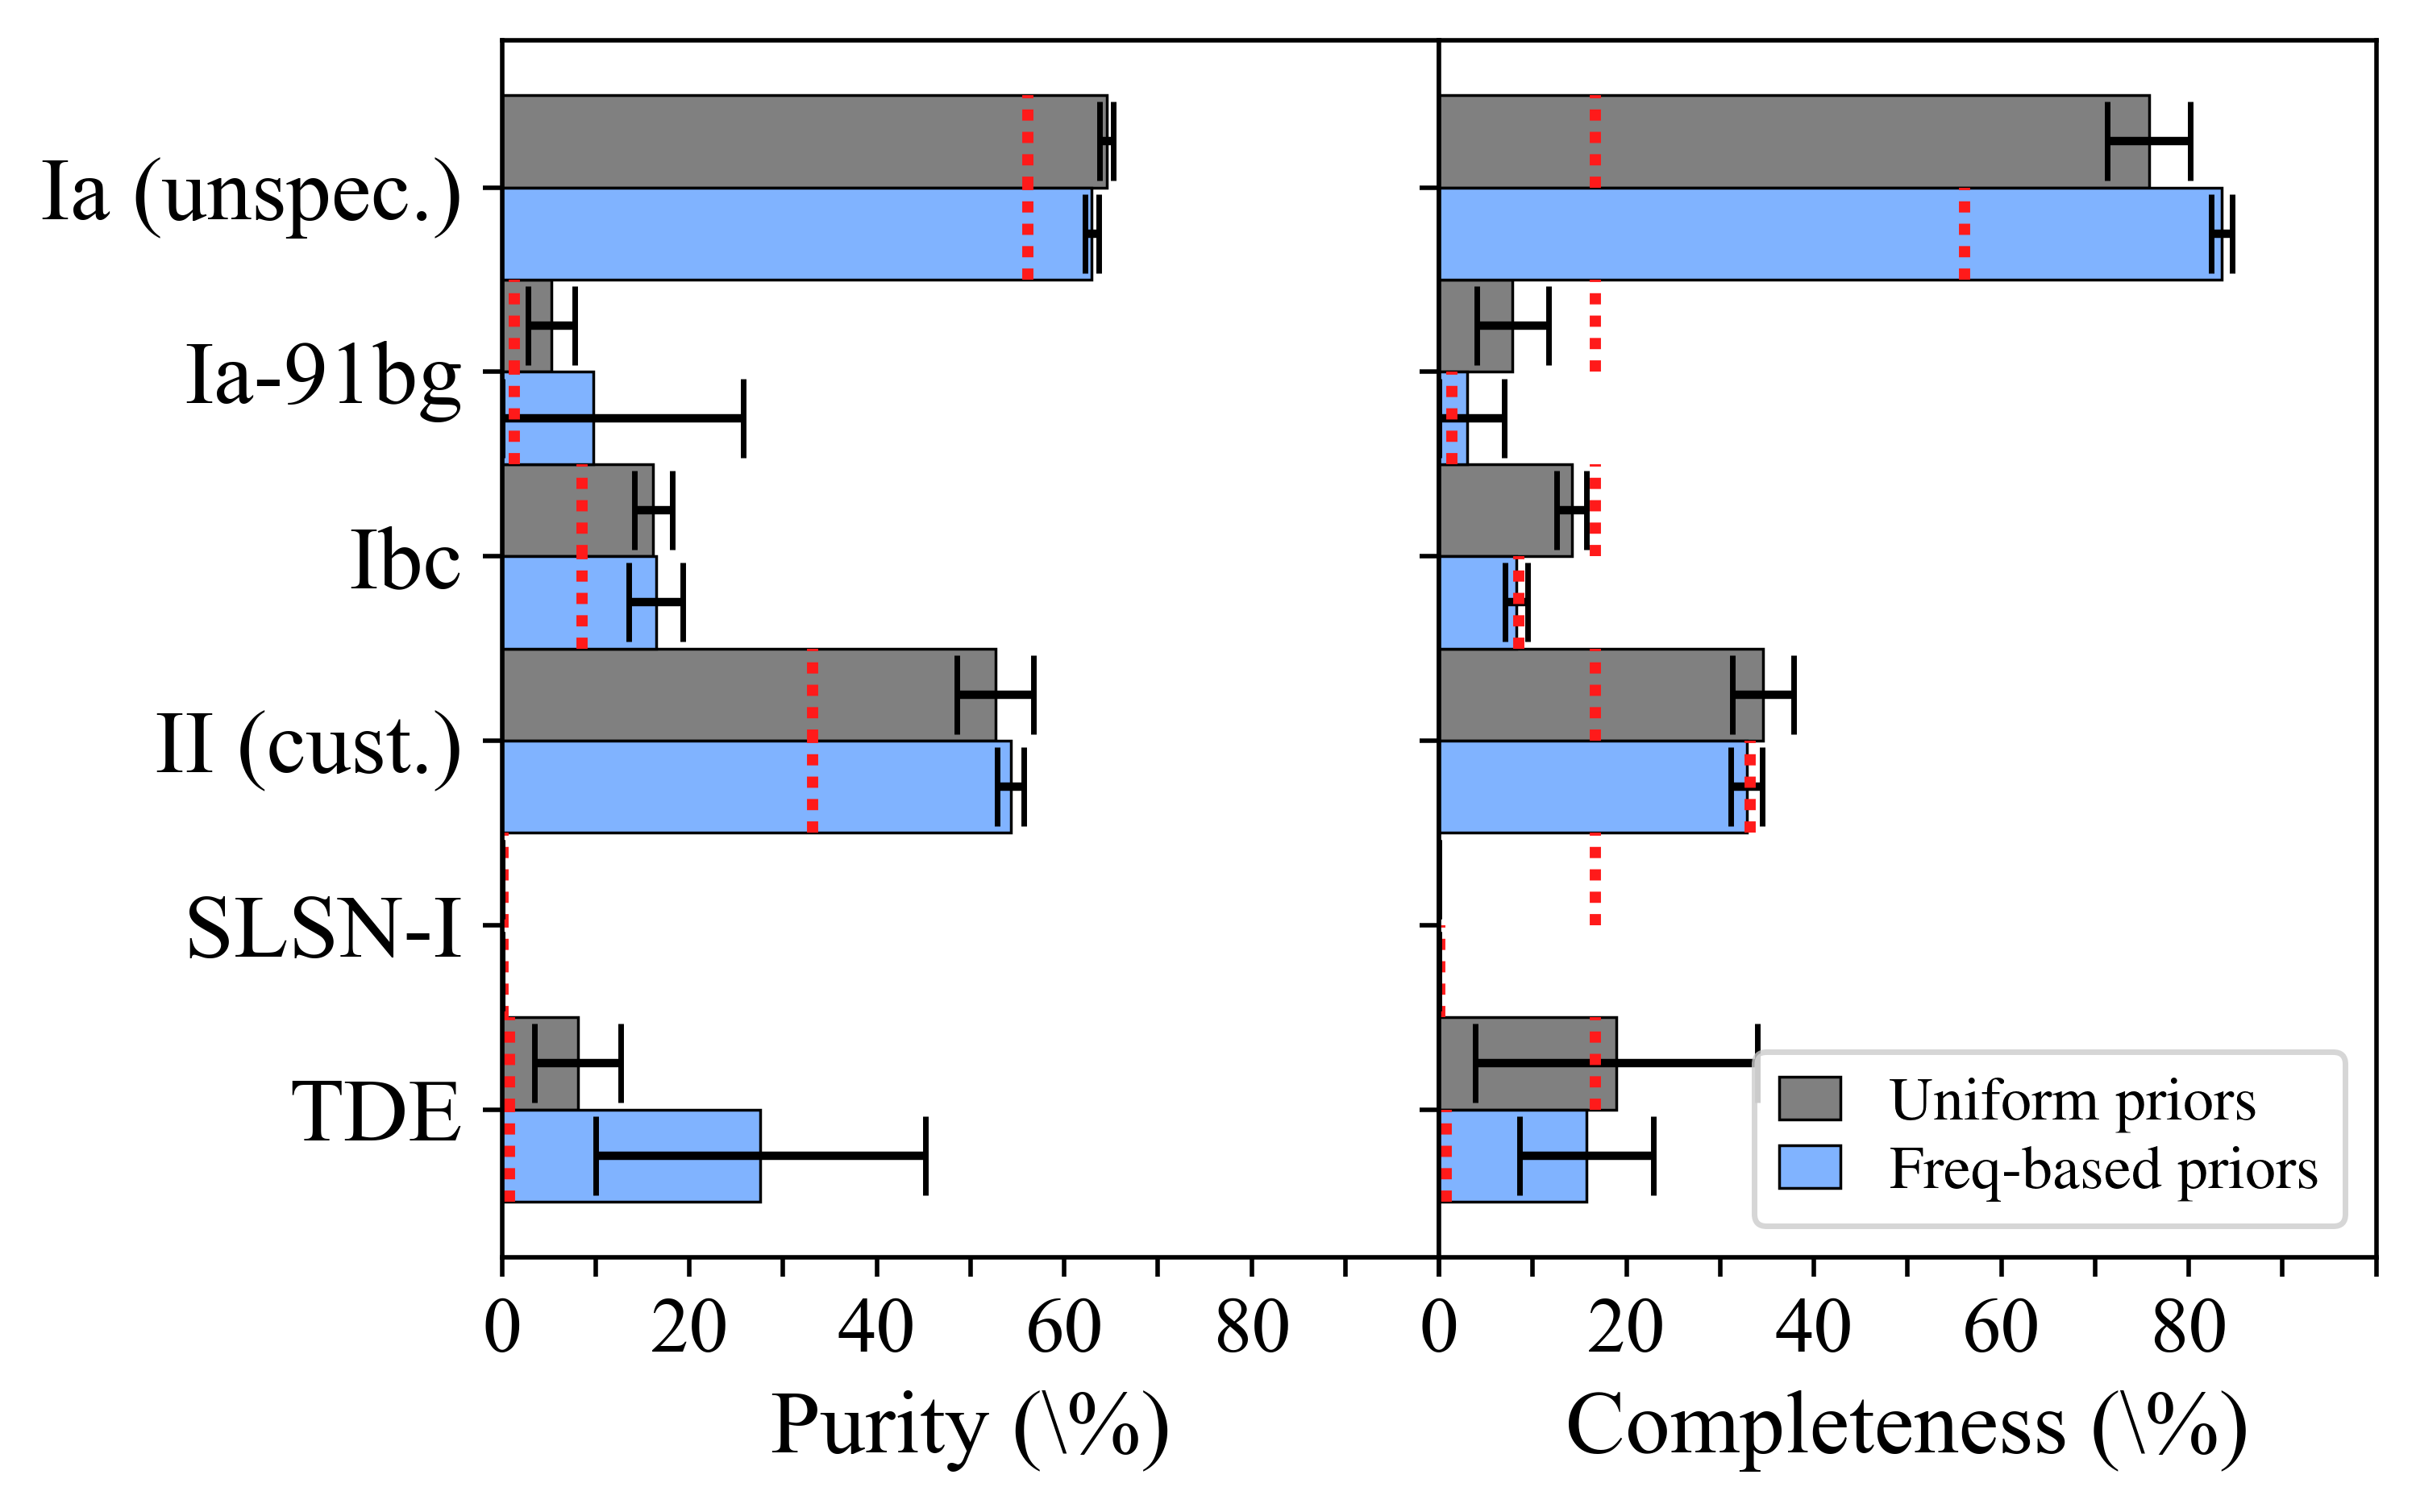

In [5]:
from mainmodel.helper_compute import *
from thex_data.data_consts import * 

def get_model_stats(model): 
    N = model.num_runs if model.num_runs is not None else model.num_folds
    pc_per_trial = model.get_pc_per_trial(model.results)
    ps, cs = model.get_pc_performance(pc_per_trial)
    c_baselines, p_baselines = compute_baselines(
        model.class_counts, 
        model.class_labels,
        model.get_num_classes(), 
        model.balanced_purity,  
        model.class_priors)
    p_intvls, c_intvls = compute_confintvls(pc_per_trial, model.class_labels, model.balanced_purity)
    
    p_class_names, p_metrics, p_b, p_intvls = get_ordered_metrics(
            ps,
            p_baselines,
            p_intvls)
    
    c_class_names, c_metrics, c_b, c_intvls = get_ordered_metrics(
            cs,
            c_baselines,
            c_intvls)
    
    m_stats = {"Purity":[p_class_names,p_metrics,p_b,p_intvls],
              "Completeness":[c_class_names, c_metrics, c_b, c_intvls]}
    return m_stats
         
def plot_m(ax, indices, errs, baselines, metrics, name, color):

#     bar_width=0.1
    bar_width= 1 / (len(indices)  *2)
    if len(indices)>6:
        capsize=4
    else:
        capsize=7
    ax.barh(y=indices, 
            width=metrics, 
            height=bar_width, 
            xerr=errs,
            capsize=capsize, 
            linewidth=0.5,
            edgecolor=BAR_EDGE_COLOR, 
            ecolor=INTVL_COLOR, 
            color=color,
            label=name)
    for index, baseline in enumerate(baselines):
        y_val = indices[index]
        ax.vlines(x=baseline,
                   ymin=y_val - (bar_width / 2),
                   ymax=y_val + (bar_width / 2),
                   linewidth=2,
               linestyles=(0, (1, 1)), colors=BSLN_COLOR)
            
def plot_priors_together(axis, WP_model, WP_model_stats, NP_model, NP_model_stats, plot_type):
    m1_class_names, m1_metrics, m1_b, m1_intvls  = WP_model_stats[plot_type]
    m2_class_names, m2_metrics, m2_b, m2_intvls  = NP_model_stats[plot_type]
    WITHOUT_COLOR = "#808080" # without 
    WITH_COLOR = "#80b3ff" # with
        
    m1_errs = prep_err_bars(m1_intvls, m1_metrics) 
    m1_indices = np.linspace(0,1,len(multi_w.class_labels))
    bar_width= 1 / (len(m1_indices) *2)
    m2_indices = m1_indices - bar_width
     
    L = len(multi_w.class_labels)
    m2_indices = np.linspace(0,1,L+1)
    m1_indices = m2_indices + bar_width
    
    m2_indices=m2_indices[:-1]
    m1_indices=m1_indices[:-1]
    
    # Print performance per class Plus/minus 95% confidence
    print("\n"+plot_type+" stats:")
    for index, cn in enumerate(m1_class_names):
        cur_met_W= m1_metrics[index]
        d_W = (m1_intvls[index][1]-m1_intvls[index][0])/2
        print(cn+ " WP : " + str(round(cur_met_W,3)*100) + "\% \pm " + str(round(d_W,4)*100) +"\%")
        
        cur_met_WO = m2_metrics[index]
        d_WO = (m2_intvls[index][1]-m2_intvls[index][0])/2
        print(cn+ " NP : " + str(round(cur_met_WO,3)*100) + "\% \pm " + str(round(d_WO,4)*100) +"\%")
        
#         # calculate if significant
        if cur_met_W>cur_met_WO:
            if cur_met_W-d_W > cur_met_WO+d_WO:
                print("SIGNIFICANT model comp.")
        else:
            if cur_met_W+d_W < cur_met_WO-d_WO:
                print("SIGNIFICANT model comp.")
        baseline = m1_b[index]
        if cur_met_W-d_W>baseline:
            print("SIGNIFICANT ABOVE RANDOM, WITH")
        if cur_met_WO-d_WO>baseline:
            print("SIGNIFICANT ABOVE RANDOM, WITHOUT PRIORS")
        
    
    m2_errs = prep_err_bars(m2_intvls, m2_metrics)
    
    plot_m(ax=axis, indices=m1_indices, errs=m2_errs, baselines=m2_b, 
           metrics=m2_metrics, color=WITHOUT_COLOR, name=NP_model.name)
    plot_m(ax=axis, indices=m2_indices, errs=m1_errs, baselines=m1_b, 
           metrics=m1_metrics, color=WITH_COLOR, name=WP_model.name)
    # Figure formatting
    axis.set_xlim(0, 1)
    axis.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1])
    axis.set_xticklabels(["0", "", "20", "", "40", "", "60", "", "80", "", ""], fontsize=14)
    axis.set_xlabel(plot_type+" (\%)", fontsize=16)  
    if plot_type == "Purity": 
#         ylabel_points = [0.15, 0.35, 0.55, 0.75, 0.95]
        
        ylabel_points = m1_indices-(bar_width/2)
        axis.set_yticks(ylabel_points)
        axis.set_yticklabels(clean_class_names(m1_class_names),  fontsize=16,
                       horizontalalignment='right')
    else:
        axis.legend(fontsize=11, loc="best", labelspacing=.2, handlelength=1)


f, ax = plt.subplots(nrows=1, ncols=2,
                     sharex=True, sharey=True,
                     figsize=(6,4),  dpi=500)

rc('text', usetex=True)
mpl.rcParams['font.serif'] = ['times', 'times new roman']
mpl.rcParams['font.family'] = 'serif'

print("\n\n --------------- WITH Priors -------------------- \n")
WP_stats =  get_model_stats(multi_w) # WP = with priors

print("\n\n --------------- WITHOUT Priors -------------------- \n")
NP_stats = get_model_stats(multi_wo) # NP = no priors
multi_w.name = "Freq-based priors"
multi_wo.name = "Uniform priors"


plot_priors_together(axis=ax[0],
                     WP_model=multi_w, 
                     WP_model_stats=WP_stats, 
                     NP_model=multi_wo, 
                     NP_model_stats=NP_stats, 
                     plot_type="Purity")
plot_priors_together(axis=ax[1],
                     WP_model=multi_w, 
                     WP_model_stats=WP_stats, 
                     NP_model=multi_wo, 
                     NP_model_stats=NP_stats, 
                     plot_type="Completeness")

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("../output/custom_figures/prior_comp_combined.pdf", bbox_inches='tight')
plt.show() 

#### combine probability plots for w priors vs without priors

['Unspecified Ia', 'Ia-91bg', 'TDE', 'SLSN-I', 'Ibc', 'II (cust.)']

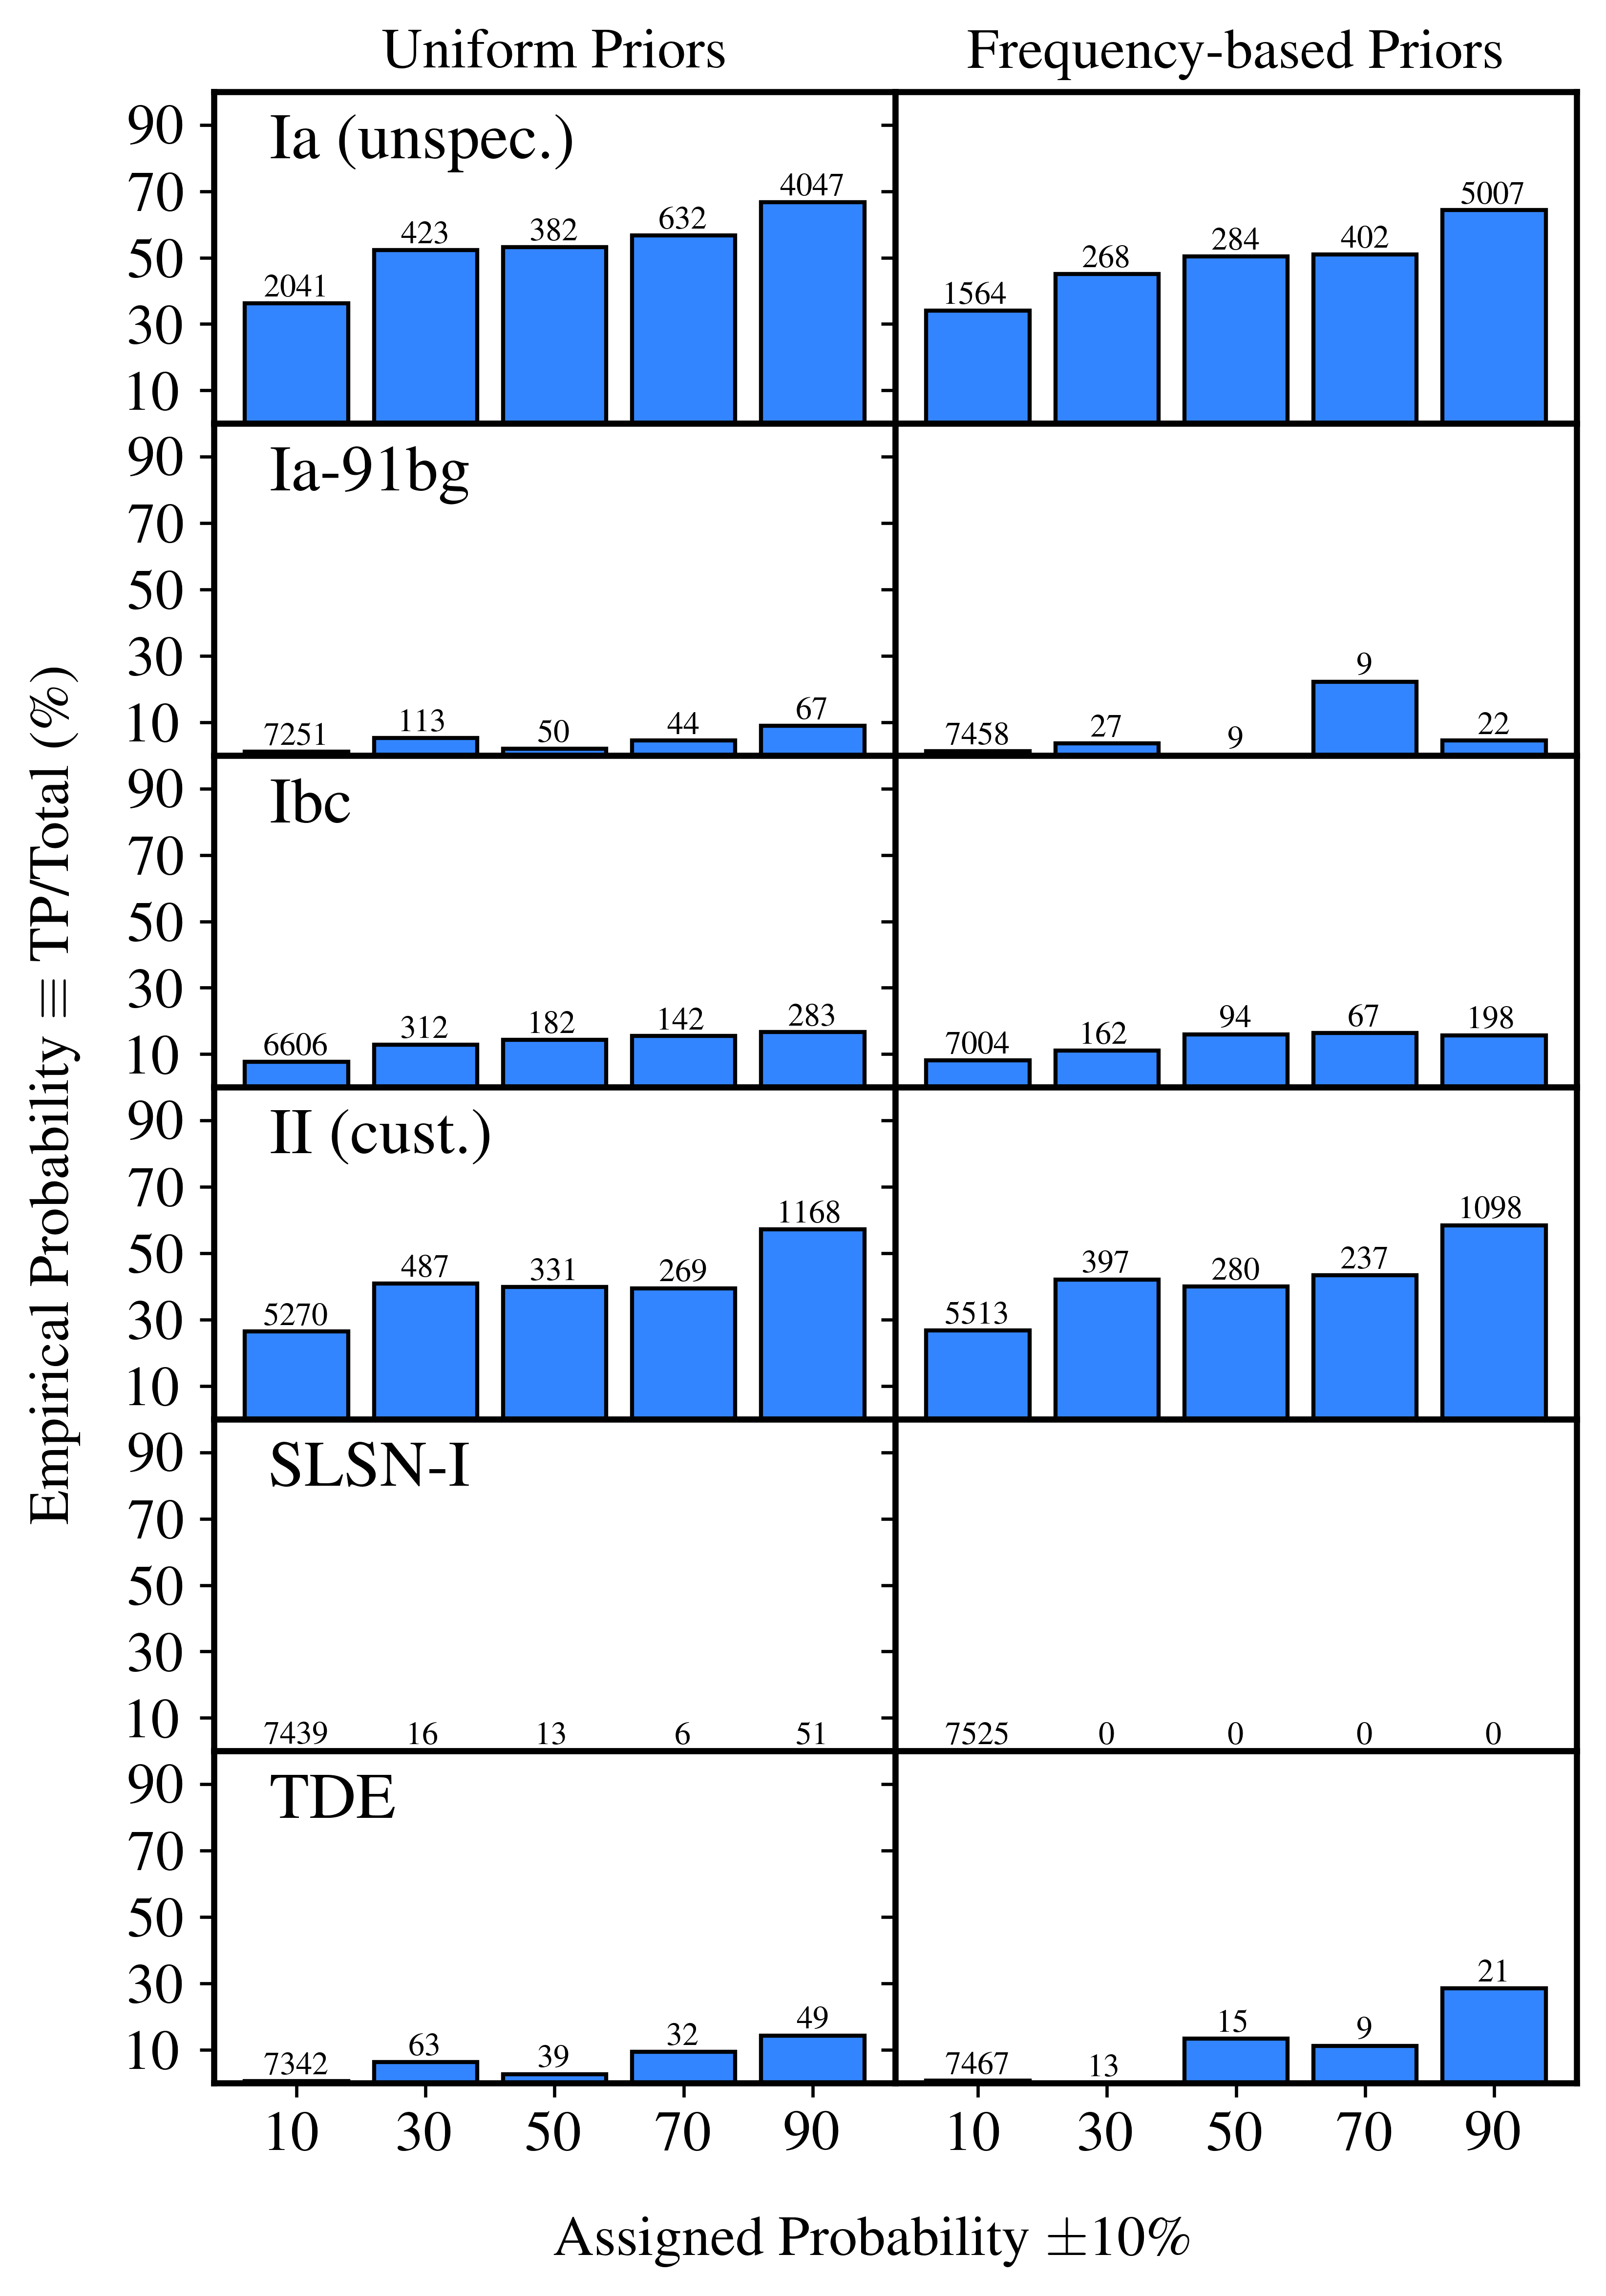

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from thex_data.data_consts import ROOT_DIR
from mainmodel.helper_plotting import *

multi_w.range_metrics = multi_w.compute_probability_range_metrics(
        multi_w.results, bin_size=0.2)
multi_wo.range_metrics = multi_wo.compute_probability_range_metrics(
        multi_wo.results, bin_size=0.2)


rc('text', usetex=True) 
mpl.rcParams['font.serif'] = ['times', 'times new roman']
mpl.rcParams['font.family'] = 'serif'

# class_labels = multi_w.class_labels
# multi_w.class_labels = ["Unspecified Ia", "Ia-91bg", "Ibc", "Unspecified II",  "TDE" ]
class_labels = ['Unspecified Ia', 'Ia-91bg', 'Ibc', 'II (cust.)',  'SLSN-I', 'TDE']
num_classes = len(multi_w.class_labels) 
f, ax = plt.subplots(nrows=num_classes,
                     ncols=2,
                     sharex=True, sharey=True,
                     figsize=(FIG_WIDTH, 9),
                     dpi=DPI)
plot_index = 0
for class_index in range(len(class_labels)):
    if plot_index == 0:
        # Add titles to top of plots
        ax[plot_index][0].set_title("Uniform Priors", fontsize=14)
        ax[plot_index][1].set_title("Frequency-based Priors", fontsize=14)
        

    class_name = class_labels[class_index]  
    plot_model_rates(class_name, multi_wo, ax[plot_index][0])
    plot_model_rates(class_name, multi_w, ax[plot_index][1])
    
    pretty_class_name = clean_class_name(class_name)
    ax[plot_index][0].text(-0.2, 0.8, pretty_class_name, fontsize=16) 
    plot_index += 1

y_indices = [0.1, 0.3, 0.5, 0.7, 0.9]
y_ticks = ["10", "30", "50", "70", "90"]
# x and y indices/ticks are the same
plt.xticks(np.arange(5), y_ticks)
plt.yticks(y_indices, y_ticks)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

f.text(0.5, 0.06, 'Assigned Probability' + r' $\pm$10\%', fontsize=14, ha='center')
f.text(0.02, .5, r'Empirical Probability $\equiv$ TP/Total ($\%$)',
           fontsize=14, va='center', rotation='vertical')

plt.subplots_adjust(wspace=0, hspace=0)

f.savefig(ROOT_DIR + "/output/custom_figures/merged_metrics_priors_comp.pdf", bbox_inches='tight')
plt.show()

In [8]:
multi_w.class_prob_rates

{'Unspecified Ia': array([0.3402, 0.4515, 0.5035, 0.51  , 0.6429]),
 'Ia-91bg': array([0.013 , 0.037 , 0.    , 0.2222, 0.0455]),
 'TDE': array([0.0066, 0.    , 0.1333, 0.1111, 0.2857]),
 'SLSN-I': array([0.0008, 0.    , 0.    , 0.    , 0.    ]),
 'Ibc': array([0.0811, 0.1111, 0.1596, 0.1642, 0.1566]),
 'II (cust.)': array([0.2672, 0.4207, 0.4   , 0.4346, 0.5847])}

In [ ]:
# f, ax = plt.figure(figsize=(4, 4), dpi=200)

f, ax = plt.subplots(nrows=1,
                     ncols=1,
#                      sharex=True, sharey=True,
                     figsize=(4,4),
                     dpi=280)

multi_range_metrics = multi_w.compute_probability_range_metrics(
        multi_w.results)
mirror_ax = plot_model_curves(
            "TDE", multi_w, multi_range_metrics, ax)

In [ ]:
np[3,3,4] +[2,1,1]

In [ ]:
# for class_index, class_name in enumerate(multi_w.class_labels): 
class_name = "TDE"
results = np.concatenate(multi_w.results)
label_index = len(multi_w.class_labels)
TP_counts = [0,0,0,0,0,0,0,0,0,0]
total_counts = [0,0,0,0,0,0,0,0,0,0]
for row in results:
    labels = row[label_index]
    is_class = multi_w.is_class(class_name, labels)

    # Get class index of max prob; exclude last column since it is label
    max_class_prob = np.max(row[: len(row) - 1])
    max_class_index = np.argmax(row[: len(row) - 1])
    max_class_name = multi_w.class_labels[max_class_index]
    
    bins = np.arange(0, 1.01, 0.1)
    counts, ranges = np.histogram([max_class_prob], bins=bins) 

    if max_class_name == "TDE":
        total_counts=np.add(counts, total_counts)
        if is_class:
            TP_counts=np.add(counts, TP_counts) 

In [ ]:
TP_counts

In [ ]:
total_counts

In [ ]:
# # for i in range()
# a = list(range(10))
# a.reverse()
# for index in a:
#     print(TP_counts[index] total_counts[index])

In [ ]:
for i,TP in enumerate(TP_counts):
    print(str(TP) + "/"+ str(total_counts[i]))
    
# 50%
(1+1+3)/(8+7+6+4+23)

## Example output plots

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mainmodel.helper_compute import *
from thex_data.data_consts import *
import utilities.utilities as thex_utils

model = MultiModel(folds=3,
                   min_class_size = 40,   
                   priors = True,
                   transform_features = True,
                   cols = mags, 
                   lsst_test=True)  
model.run_model()

Want to find 16 quality examples

8: good & correct examples with wide dist
    correct examples for II P, IIn, TDE, GRB, Ib (unspec.)

4: not 'good' but correct examples (high prob on Ia or something)

4: incorrect, but benefit from empirical prob plots (so look for maybe Ia with probs 20-49%, where Ia IS the correct answer but something else won; or could show 4 GRB plots with probs >80%, and half are correct but half are not- this exemplifies its 50% empriical prob at the range. 



In [ ]:
model = MultiModel(folds=3,
                   min_class_size = 40,   
                   priors = True,
                   transform_features = True,
                   cols = mags, 
                   lsst_test=True)  


In [ ]:
model.run_model()

In [ ]:
def plot_on_ax(axis, model, do_index, preds):
    """
    Plot example on given ax
    """
#     if do_index == -1:
        # Custom sample ; put Ia-91bg prob at range 
    row = preds[do_index] 
    labels = row[len(row) - 1]
    true_class_index = None

    for class_index, class_name in enumerate(model.class_labels):
        if class_name in thex_utils.convert_str_to_list(labels):
            true_class_index = class_index


    ACC = "#ccccff"# actual class color, light blue
    DCC = "#0000cc" # default class color, dark blue

    colors = [DCC] * len(model.class_labels)
    colors[true_class_index] = ACC
    probabilities = row[0:len(row) - 1]  
    bar_size = 0.05
    x_indices = np.linspace(0,
                            len(model.class_labels) * bar_size,
                            len(model.class_labels))
    axis.bar(x=x_indices, height=probabilities,  
             width=bar_size, 
             color=colors, edgecolor='black')
    axis.tick_params(axis="y",direction="in")
    axis.set_ylim([0, 1]) 
    
    



In [ ]:
preds = np.concatenate(model.results)

In [ ]:
#  use following to find good samples.
use_indices = []
USE_CLASS = "Unspecified Ia"
for index, row in enumerate(preds):
    labels = row[len(row) - 1]
    if USE_CLASS in labels:
        if row[0] > 0.5 and row[0] <0.65:
            use_indices.append(index)

for do_index in use_indices:
    f, ax = plt.subplots(nrows=1, ncols=1,  figsize=(4,2), dpi=DPI)
    plot_on_ax(ax, model, do_index, do_index, preds) 
    bar_size = 0.05
    x_indices = np.linspace(0, len(model.class_labels) * bar_size, len(model.class_labels))
    ax.set_xticks(ticks=x_indices)
    xticksize = 11
    pretty_class_names = clean_class_names(model.class_labels) 
    ax.set_xticklabels(labels=pretty_class_names, fontsize=xticksize, rotation = -90)


    plt.savefig(model.dir + "/examples/"+USE_CLASS+"/sample_" + str(do_index) + ".pdf", 
                bbox_inches='tight')

In [ ]:
indices = [[2964, 2965, 6032, 9136],  # Good , 9140
          [2400, 2394, 9103, 9140], # good too 
          [2974, 3031, 2378, 2461]]  # wrong, low probs
#           [xx, xx, xx, xx]] #wrong but empirical probs would help a lot.
rows, cols = np.array(indices).shape

f, ax = plt.subplots(nrows=rows,
                     ncols=cols,
                     sharex=True, sharey=True,
                     figsize=(6,5),
                     dpi=DPI)
do_index = 0
example_num = 1
for row_index, index_set in enumerate(indices): 
    cur_ax = ax[row_index]
    for plot_index, do_index in enumerate(index_set): 
        plot_on_ax(cur_ax[plot_index], model, do_index, preds)
        if str(example_num) == "1":
            cur_ax[plot_index].text(.17,.8,  str(example_num), style='italic',fontsize=15)
        else:
            cur_ax[plot_index].text(.23,.8,  str(example_num), style='italic',fontsize=15)
        example_num+=1
        
        if plot_index==0:
            yticks = np.arange(0,1.2,.2)
            cur_ax[plot_index].set_yticks(ticks=yticks)
            cur_ax[plot_index].set_yticklabels(labels=[str(int(i*100)) for i in yticks],
                                               fontsize=12)


f.text(.04, 0.4, 'Probability (\%)', fontsize=14, ha='center', rotation =90)
bar_size = 0.05
x_indices = np.linspace(0, len(model.class_labels) * bar_size,
                            len(model.class_labels))


pretty_class_names = clean_class_names(model.class_labels) 
xticksize = 13
for i in range(cols):
    ax[rows-1][i].set_xticks(ticks=x_indices)
    ax[rows-1][i].set_xticklabels(labels=pretty_class_names, fontsize=xticksize, rotation = -90)
plt.subplots_adjust(wspace=0, hspace=0, left=0.1)

plt.savefig("../output/custom_figures/lsst_examples.pdf", bbox_inches='tight')
plt.show()




In [ ]:
import pickle
with open('../output/custom_figures/full_model_data.pickle', 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Archive
### Probability purity/completeness plots 
Old way of using normal purity and completeness

In [ ]:


def plot_model_curves(class_name, model, ax):
    """
    Plots rates for this model/class on axis, with annotations
    """
    purities, comps = get_pc_per_range(model, class_name)

    def plot_axis(ax, data, color):
        """
        Plot data on axis in certain color
        """
        x_indices = np.linspace(0, 1, 11)[:-1]

        
        print("Data: " + str(data))
        # Do not plot points whose data is 0; so that we may distinguish between true 0 purity and having no data. 
        # If both purity and completeness are 0 we do not plot.
        total_range_counts=model.range_metrics[class_name][1]
        keep_indices = []
        keep_data = []
        for i, t in enumerate(total_range_counts):
            if t != 0:
                keep_indices.append(x_indices[i])
                keep_data.append(data[i])
                
        ax.scatter(keep_indices, keep_data, color=color, s=4)
        ax.plot(keep_indices, keep_data, color=color, linewidth=2)
        ax.set_yticks([])  # same for y ticks
        ax.set_ylim([0, 1])

    print("\n\n P-C metrics for : " + class_name)
    plot_axis(ax, comps, C_BAR_COLOR)
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylim([0, 1])
    plot_axis(ax2, purities, P_BAR_COLOR)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(1.5)
    return ax2


def plot_pc_curves_together(binary_model, ova_model, multi_model, indices=None):
    """
    Plot class versus probability rates of all three classifiers together
    :param indices: class indices to plot
    """
    class_labels = ova_model.class_labels
    num_classes = len(ova_model.class_labels)
    if indices is not None:
        num_classes = len(indices)
    f, ax = plt.subplots(nrows=num_classes,
                         ncols=3,
                         sharex=True, sharey=True,
                         figsize=(FIG_WIDTH, 10),
                         dpi=DPI)

    y_indices = [0, 0.2, 0.4, 0.6, 0.8, 1]
    y_ticks = ["0", "20", "40", "60", "80", ""]

    plot_index = 0
    for class_index in range(len(class_labels)):
        if indices is not None and class_index not in indices:
            continue

        if plot_index == 0:
            # Add titles to top of plots
            ax[plot_index][0].set_title("Binary", fontsize=TICK_S)
            ax[plot_index][1].set_title("OVA", fontsize=TICK_S)
            ax[plot_index][2].set_title("Multi", fontsize=TICK_S)

        class_name = class_labels[class_index]
        print("Binary model")
        plot_model_curves(class_name, binary_model, ax[plot_index][0])
        print("OVA model")
        plot_model_curves(class_name, ova_model, ax[plot_index][1])
        print("KDE Multi model")
        mirror_ax = plot_model_curves(class_name, multi_model, ax[plot_index][2])

        ax[plot_index][0].set_yticks(ticks=y_indices)
        ax[plot_index][0].set_yticklabels(labels=y_ticks, color=P_BAR_COLOR)
        mirror_ax.set_yticks(ticks=y_indices)
        mirror_ax.set_yticklabels(labels=y_ticks, color=C_BAR_COLOR)
        ax[plot_index][0].tick_params(axis='both', direction='in', labelsize=10)
        ax[plot_index][1].tick_params(axis='both', direction='in')
        ax[plot_index][2].tick_params(axis='both', direction='in', labelsize=10)

        mpl.rcParams['font.serif'] = ['times', 'times new roman']
        mpl.rcParams['font.family'] = 'serif'
        pretty_class_name = clean_class_name(class_name)
        ax[plot_index][0].text(0, 0.85, pretty_class_name, fontsize=14)
        plot_index += 1

    x_indices = np.linspace(0, 1, 11)[:-1]

    plt.xticks(x_indices, ["", "10", "", "30", "", "50", "", "70", "", "90"])
    rc('text', usetex=True)
    f.text(0.5, 0.08, r'Probability $\geq$X\%', fontsize=TICK_S, ha='center')
    f.text(0.03, .5, 'Purity (\%)',
           fontsize=TICK_S, va='center', rotation='vertical', color=P_BAR_COLOR)
    f.text(0.98, .5, 'Completeness (\%)',
           fontsize=TICK_S, va='center', rotation='vertical', color=C_BAR_COLOR)

    plt.subplots_adjust(wspace=0, hspace=0)

    f.savefig("../output/custom_figures/merged_pc_curves_" +
              str(indices) + ".pdf", bbox_inches='tight')
    plt.show()
    
    


ova_model.range_metrics = ova_model.compute_probability_range_metrics(
        ova_model.results, bin_size=0.1)
binary_model.range_metrics = binary_model.compute_probability_range_metrics(
        binary_model.results, bin_size=0.1)
multi_model.range_metrics = multi_model.compute_probability_range_metrics(
        multi_model.results, bin_size=0.1)

plot_pc_curves_together(binary_model, ova_model, multi_model, indices=[0,1,2,3,4,5])
plot_pc_curves_together(binary_model, ova_model, multi_model, indices=[6,7,8,9,10,11])
plot_pc_curves_together(binary_model, ova_model, multi_model, indices=[0,7,8,9,10,11])
